<a href="https://colab.research.google.com/github/bhomaidan1990/Computer_Vision_Labs/blob/main/CV_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Course
## Lab 3 Pyramids

In [1]:
##########################
# @Authors:              #
#     Belal Hmedan       #
# &   Junyi ZHONG        #
##########################
#
#========================
# Import Libraries
#========================
import os
import glob
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from keras.preprocessing import image
import cv2
import time
import math
import keras 
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#--------------------------------------------
from skimage import exposure as exposure
from scipy.ndimage import affine_transform

#### Reproducible Code Initialization

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

### Download the Dataset and related files

In [3]:
#=======================
# Download the dataset
#=======================
# !rm originalPics.tar.gz & rm FDDB-folds.tgz & rm test_db.zip
# !rm -rf Dataset & rm -rf FDDB-folds & rm -rf sample_data & rm -rf NewDataset
#
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
# ================
# Wider DataSet
# ================
# !wget https://drive.google.com/u/0/uc?export=download&confirm=BkuU&id=0B6eKvaijfFUDbW4tdGpaYjgzZkU
# !wget https://drive.google.com/u/0/uc?export=download&confirm=aArG&id=0B6eKvaijfFUDd3dIRmpvSk8tLUk
# !wget https://drive.google.com/u/0/uc?export=download&confirm=GOPW&id=0B6eKvaijfFUDQUUwd21EckhUbWs
#-----------------------
# Test_Data
#==================
!wget http://crowley-coutaz.fr/jlc/Courses/2020/GVR.VO/test_db.zip
!unzip test_db.zip & mv TESTSET test
#-----------------------------------------------------------
# Extract the data
#==================
t0 = time.time()
!mkdir original && tar xvzf originalPics.tar.gz -C original
!tar xvzf FDDB-folds.tgz
!rm originalPics.tar.gz & rm FDDB-folds.tgz & rm test_db.zip & rm -rf sample_data
# # create the output dataset folder
# #-----------------------------------------------------------
# if (not os.path.isdir('Dataset')):
#     os.mkdir('Dataset')
# #-------------------------------------------------
# for im in glob.glob('/content/original/**/*.jpg', recursive=True):
#     # print(im)
#     shutil.copy(im, 'Dataset')
# #-------------------------------------------------
t1 = time.time()
print('DeCompressing Time is : ',t1-t0," seconds")

Streaming output truncated to the last 5000 lines.
2003/07/07/big/img_908.jpg
2003/07/01/big/img_250.jpg
2003/05/28/big/img_52.jpg
2002/11/06/big/img_476.jpg
2003/04/17/big/img_859.jpg
2002/09/30/big/img_903.jpg
2002/11/20/big/img_854.jpg
2003/02/23/big/img_874.jpg
2003/06/12/big/img_29.jpg
2003/03/10/big/img_518.jpg
2002/07/24/big/img_789.jpg
2003/03/10/big/img_327.jpg
2003/06/03/big/img_331.jpg
2002/09/04/big/img_13147.jpg
2002/07/23/big/img_306.jpg
2002/10/17/big/img_577.jpg
2002/08/08/big/img_981.jpg
2002/11/25/big/img_499.jpg
2002/12/18/big/img_347.jpg
2002/07/22/big/img_602.jpg
2003/07/17/big/img_341.jpg
2002/11/18/big/img_608.jpg
2003/07/02/big/img_367.jpg
2003/05/23/big/img_411.jpg
2002/12/10/big/img_717.jpg
2002/11/01/big/img_694.jpg
2002/11/26/big/img_258.jpg
2002/09/18/big/img_884.jpg
2002/10/22/big/img_1198.jpg
2003/03/10/big/img_748.jpg
2002/12/06/big/img_921.jpg
2003/07/18/big/img_30.jpg
2002/11/24/big/img_830.jpg
2002/11/01/big/img_193.jpg
2002/07/26/big/img_207.jpg
2003

### Q1: Scale-invariant Gaussian pyramid

(512, 768, 3)


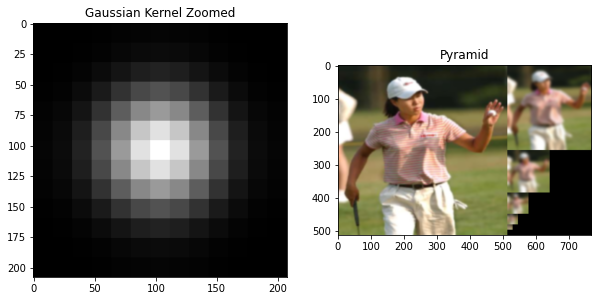

In [47]:
#=================
# Resize Function
#=================   
def _resize(image, downscale, minSize=(30, 30)):
    if(image.shape > minSize ):
        newSize = (image.shape[0]// downscale, image.shape[1]//downscale)
        newImage = cv2.resize(image, newSize, interpolation = cv2.INTER_NEAREST) 
        return newImage
    else:
        return 0
#--------------------------------------------------------------
#=================
# Pyramid Function
#=================  
def pyramid(image, downscale=2, sigma=1, multichannel=True):
    """pyramid function to construct a gaussian pyramid.

    Parameters
    ----------  
    @param: image : ndarray
        Input image.
    @param: downscale : float, optional
        Downscale factor.
    @param: sigma : float, optional
        Sigma for Gaussian filter. Default is `2 * downscale / 6.0` which
        corresponds to a filter mask twice the size of the scale factor that
        covers more than 99% of the Gaussian distribution.
    @param: multichannel : bool, optional
        Whether the last axis of the image is to be interpreted as multiple
        channels or another spatial dimension. Default is True.
    """
    # Assert scale factor is bigger than 1
    if downscale <= 1:
        raise ValueError('scale factor must be greater than 1')
    # Default sigma
    if sigma is None:
        # automatically determine sigma which covers > 99% of distribution
        sigma = 2 * downscale / 6.0
    # Initialize
    # resize original image to 512 * 512
    image = cv2.resize(image, (512, 512), interpolation = cv2.INTER_NEAREST)
    # create an array to store the pyramid
    if multichannel:
        Pyramid_arr = np.zeros((image.shape[0], math.floor(1.5*image.shape[1]), 3), dtype=int)
    else:
        Pyramid_arr = np.zeros((image.shape[0], math.floor(1.5*image.shape[1])), dtype=int)
    # Original image:
    #Pyramid_arr[:, :image.shape[1]] = _smooth(image, sigma=sigma, downscale=downscale, multichannel=multichannel)
    Pyramid_arr[:, :image.shape[1]] = cv2.GaussianBlur(image, (int(6*sigma+1), int(6*sigma+1)), sigma)
    # Resized_images
    rows = 0
    cols = image.shape[1]
    newSigma = math.ceil(4*sigma)
    while type(_resize(image, downscale=downscale)) != int:
        # image =_smooth(image, sigma=4*sigma, downscale=downscale, multichannel=multichannel)
        image = cv2.GaussianBlur(image, (math.ceil(6*newSigma)+1, math.ceil(6*newSigma)+1), newSigma)
        image = _resize(image, downscale=downscale)
        n = image.shape[0]
        m = image.shape[1]
        Pyramid_arr[rows: rows+n, cols:cols+m] = image
        rows += n 
    return Pyramid_arr
#-----------------------------------------------------------------
def gaussian_kernel(sigma):

    # create delta image
    dims = 6*sigma+1
    dims2 = dims // 2
    delta = np.zeros((dims,dims,3), dtype=np.float32)
    delta[dims2:dims2+1, dims2:dims2+1] = (255,255,255)

    # blur image
    blur = cv2.GaussianBlur(delta, (0,0), sigmaX=sigma, sigmaY=sigma)

    # resize 16x
    dims4x = dims * 16
    resized = cv2.resize(blur, (dims4x,dims4x), interpolation = cv2.INTER_AREA)

    # stretch to full dynamic range
    result = exposure.rescale_intensity(resized, in_range='image', out_range=(0,255)).astype(np.uint8)
 
    return result
#-----------------------------------------------------------------
#-----------------------------------------------------------------
# Read Image
#=============
img = cv2.imread('/content/original/2002/07/19/big/img_130.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sigma = 2

Kernel = gaussian_kernel(sigma=sigma)
result = pyramid(img, sigma=sigma)
print(result.shape)
#====================
# Visualize Results
#====================
plt.figure(num="Pyramids", figsize=(10,10))

plt.subplot(121)
plt.imshow(Kernel, cmap='gray')
plt.title('Gaussian Kernel Zoomed')

plt.subplot(122)
plt.imshow(result)
plt.title('Pyramid')

plt.show()

#### Pyramid Impulse Response

In [48]:
#=========================
# Extract Pyramid Function
#=========================
def pyr_extract(pyramid_array):
    '''
    pyr_extract function to extract the images as 5x512x512x3 ndarray

    Parameters
    ----------
    @param: pyramid_array: ndarray of shape 512x768
    --------
    returns:
    extracted images as 5x512x512x3 ndarray
    
    '''
    # define empty array as container
    if len(pyramid_array.shape)==3:
        images = np.zeros((5,512,512,3))
    else:
        images = np.zeros((5,512,512))

    # Original Image Blurred
    images[0] = pyramid_array[:,:512]
    ncols = 512
    nrows1 = 0
    nrows2 = 256
    # Loop
    for i in range(1,5):
        # Get the image
        img = pyramid_array[nrows1:nrows2 ,ncols:int(ncols+(0.5**i)*ncols)].astype('float32')
        # Resize it to 512 x 512
        if len(pyramid_array.shape)==3:
            images[i,:,:,:] = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)
        else:
            images[i,:,:] = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)
        # Next image coordinates
        diff = nrows2 - nrows1
        nrows1 = nrows2
        nrows2 = nrows1 + int(diff/2)
    return images

In [49]:
#=========================
# Visualize Cube function
#=========================
def VisCube(cube):
    '''
    VisCube Function to visualize the pyramid stored in ndarray

    Parameters:
    -----------
    @paarm: cube ndarray
            5x512x512x3 cube contains 5 colored images of shape 512x512
    '''
    img_height = cube.shape[1]
    img_width  = cube.shape[2]
    nimages    = cube.shape[0]
    # print(img_height, img_width, nimages)
    bg_val = -1 # Some flag value indicating the background.
    if(len(cube.shape)==4):
        images = [cube[4-i,:,:,0] for i in range(nimages)]
    else:
        images = [cube[4-i,:,:] for i in range(nimages)]

    stacked_height = 2*img_height
    stacked_width  = img_width + (nimages-1)*img_width/2
    stacked_width = int(stacked_width)

    stacked = np.full((stacked_height, stacked_width), bg_val)

    # Affine transform matrix.
    T = np.array([[1,-1],[0, 1]])
    #T = nii_aff[1:3,1:3]
    for i in range(nimages):
        # The first image will be right most and on the "bottom" of the stack.
        o = (nimages-i-1) * img_width/2
        out = affine_transform(images[i], T, offset=[o,-o],
                            output_shape=stacked.shape, cval=bg_val)
        stacked[out != bg_val] = out[out != bg_val]

    plt.imshow(stacked)#.set_clim(0.0,200 )
    plt.axis('off')
    plt.show()

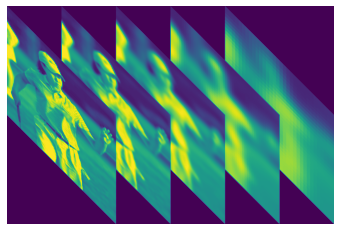

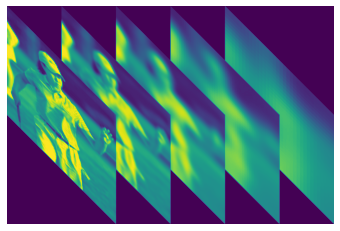

In [50]:
#=============
# Read Image
#=============
img = cv2.imread('/content/original/2002/07/19/big/img_130.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Pyramids
# Sigma
sigma = 1
result1 = pyramid(img, sigma=sigma)

# Sigma
sigma = math.sqrt(2)
result2 = pyramid(img, sigma=sigma)

#====================
# Pyramid Cube
#====================
cube1 = pyr_extract(result1)
VisCube(cube1)

cube2 = pyr_extract(result2)
VisCube(cube2)

Impulse Response

(5, 13)


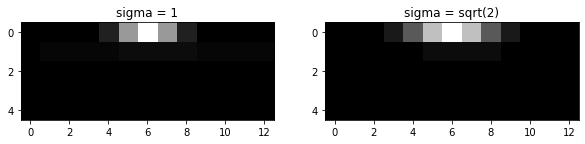

In [57]:
#====================
# Impulse Response
#====================
# First Sigma
sigma = 1
# Zeros 512x512 Black Image
delta = np.zeros((512, 512), dtype=np.float32)
# Dirac
delta[255,255] = 255
# Pyramid
deltaPyramid = pyramid(delta, sigma=sigma, multichannel=False)
# Cube the Pyramid
cube3 = pyr_extract(deltaPyramid)
ImpResp1 = cube3[:,255,249:262]

# Second Sigma
sigma2 = math.sqrt(2)
# Second Pyramid
deltaPyramid2 = pyramid(delta, sigma=sigma2, multichannel=False)
# Cube the Pyramid
cube4 = pyr_extract(deltaPyramid2)
ImpResp2 = cube4[:,255,249:262]

print(ImpResp1.shape)
#====================
# Visualize Results
#====================
plt.figure(num="Pyramids", figsize=(10,10))

plt.subplot(121)
plt.imshow(ImpResp1, cmap='gray')
plt.title('sigma = 1')

plt.subplot(122)
plt.imshow(ImpResp2, cmap='gray')
plt.title('sigma = sqrt(2)')

plt.show()

#### Comparision
The smoothing seems to be a little bit more with $sigma = \sqrt(2)$

### Q2: MLP for Face Detection

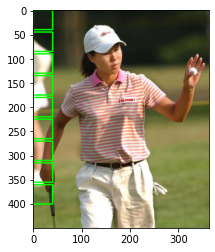

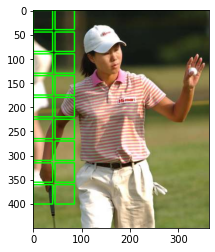

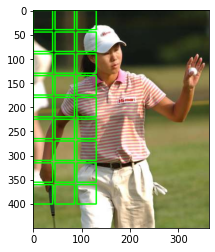

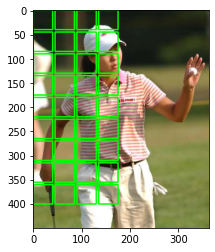

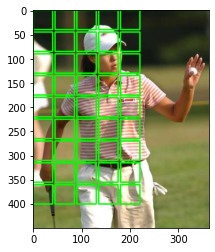

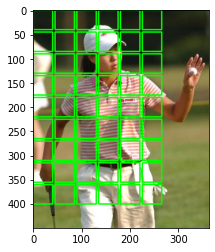

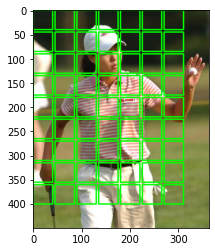

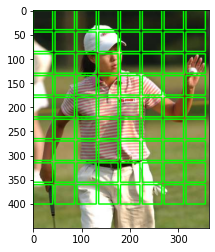

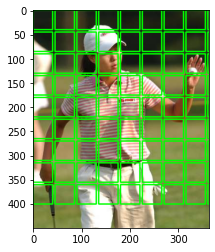

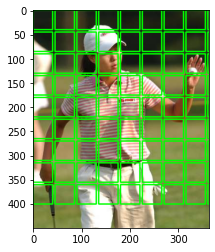

image size: (450, 363, 3)


In [58]:


image = cv2.imread("/content/original/2002/07/19/big/img_130.jpg") 
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sli_win = img 
(winW, winH) = (16, 16) # from 16*16 to 100*100
# loop over the image pyramid
# for resized in pyramid(image, sigma=1):
# 	# loop over the sliding window for each layer of the pyramid
# 	for sli_win in sliding_window_extractor(resized, stepSize=32, windowSize=(winW, winH)):
# 		# if the window does not meet our desired window size, ignore it
# 		if window.shape[0] != winH or window.shape[1] != winW:
# 			continue

def sliding_window_extractor(image, stepSize, windowSize):
 
  for row in range(0, image.shape[0], stepSize):
    for col in range(0, image.shape[1], stepSize):
          window = img[row:row + windowSize[0], col:col + windowSize[1], :]
          # Apply bestMLP to classify face from the background here
          # since I don't how to add bestMLP.h5 model here, I'll just draw the window


          cv2.rectangle(sli_win, (row, col), (row + windowSize[0], col + windowSize[1]), (0, 255, 0), 2)
          plt.imshow(np.array(sli_win).astype('uint8'))
    
          #Resize the window extracted to the input of bestMLP network
          window.resize() 
    plt.show()
    
sliding_window_extractor(img,45,(40,40))

# show all windows
# plt.show()
print('image size:',img.shape)

